# Data Preprocessing

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def load_horses_orig(path, image_size):   
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):
        
        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)
        
        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0
        
    
        images.append(low_im)
        masks.append(bin_mask)


    xtest = np.reshape(np.array(images[250:]), (-1,image_size*image_size*3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size * image_size))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size*image_size*3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size * image_size))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size * image_size))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size*image_size*3))

    return xdata, xval, xtest, ydata, yval, ytest


In [3]:
#change the path address 
path = 'horses/'
image_size = 32
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

In [4]:
def draw(image, mask):
  fig, (ax1,ax2) = plt.subplots(1,2) 
  ax1.axis('off')
  ax2.axis('off')
  ax1.imshow(np.reshape(image, (image_size,image_size,3)))
  ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
  plt.show()

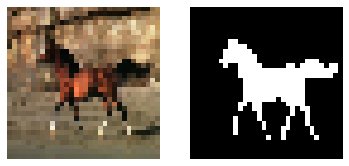

In [5]:
draw(xdata[0], ydata[0])

# Langevin Sampling

In [6]:
def sample_langevin(x, model, stepsize, n_steps, noise_scale=None, intermediate_samples=False):
    if noise_scale is None:
        noise_scale = np.sqrt(stepsize * 2)

    l_samples = []
    l_dynamics = []
    x.requires_grad = True
    for _ in range(n_steps):
        l_samples.append(x.detach().to('cpu'))
        noise = torch.randn_like(x) * noise_scale
        out = model(x)
        grad = autograd.grad(out.sum(), x, only_inputs=True)[0]
        dynamics = stepsize * grad + noise
        x = x + dynamics
        l_samples.append(x.detach().to('cpu'))
        l_dynamics.append(dynamics.detach().to('cpu'))

    if intermediate_samples:
        return l_samples, l_dynamics
    else:
        return l_samples[-1]

# Fully Connected Model

In [7]:
def get_activation(s_act):
    if s_act == 'relu':
        return nn.ReLU(inplace=True)
    elif s_act == 'sigmoid':
        return nn.Sigmoid()
    elif s_act == 'softplus':
        return nn.Softplus()
    elif s_act == 'linear':
        return None
    elif s_act == 'tanh':
        return nn.Tanh()
    elif s_act == 'leakyrelu':
        return nn.LeakyReLU(0.2, inplace=True)
    elif s_act == 'softmax':
        return nn.Softmax(dim=1)
    else:
        raise ValueError(f'Unexpected activation: {s_act}')


class FCNet(nn.Module):
    def __init__(self, in_dim, out_dim, l_hidden=(50,), activation='sigmoid', out_activation='linear'):
        super(FCNet, self).__init__()
        l_neurons = tuple(l_hidden) + (out_dim,)
        if isinstance(activation, str):
            activation = (activation,) * len(l_hidden)
        activation = tuple(activation) + (out_activation,)

        l_layer = []
        prev_dim = in_dim
        for i_layer, (n_hidden, act) in enumerate(zip(l_neurons, activation)):
            l_layer.append(nn.Linear(prev_dim, n_hidden))
            act_fn = get_activation(act)
            if act_fn is not None:
                l_layer.append(act_fn)
            prev_dim = n_hidden

        self.net = nn.Sequential(*l_layer)
        self.in_dim = in_dim
        self.out_shape = (out_dim,) 

    def forward(self, x):
        return self.net(x)
    
    

# IOU Definition

In [8]:
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    return np.average(intersect / (union+0.0))

# Training

In [ ]:
model = 'FCNet'
lr = 1e-5
stepsize= 0.1
n_steps = 100
n_epoch = 10
alpha = 1
train_iou = []
val_iou = []
test_iou = []
best_val_iou = -1
best_test_iou = -1

def predict_labels(x, y):
    for i, j in enumerate(x):
        model.eval()
        j = np.mean(j.reshape(image_size, image_size, 3), axis=2).reshape(32,32,1)
        pos_out = model(torch.from_numpy(j).float())
        neg_out = model(torch.from_numpy(y[i]).reshape(-1, image_size, image_size,1).float())
        
        predictions = np.squeeze(np.array(((pos_out - neg_out) + alpha * (pos_out ** 2 + neg_out ** 2)).detach().numpy()))
        return predictions


# build model
if model == 'FCNet':
    model = FCNet(in_dim=1, out_dim=1, l_hidden=(100, 100), activation='relu', out_activation='linear')

opt = Adam(model.parameters(), lr=lr)
    
for i_epoch in range(n_epoch):
    l_loss = []
    j=0
    for i in xdata:
        pos_x = i
        
        pos_x = np.mean(pos_x.reshape(image_size, image_size, 3), axis=2).reshape(32,32,1)
        pos_x = torch.from_numpy(pos_x)    
        neg_x = torch.randn(torch.from_numpy(ydata[j]).size())
        neg_x = neg_x.reshape(-1, image_size, image_size,1)
        j=j+1
        neg_x = sample_langevin(neg_x.float(), model, stepsize, n_steps, intermediate_samples=False)
        opt.zero_grad()
        pos_out = model(pos_x.float())
        neg_out = model(neg_x)        
#         loss = (pos_out - neg_out) + alpha * (pos_out ** 2 + neg_out ** 2)
        loss = (alpha*(pos_out/neg_out) - (pos_out-neg_out))**2
#         loss = (alpha*(min(pos_out)/max(neg_out)) - (pos_out - neg_out))**2
        loss = loss.mean()
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        opt.step()        
        l_loss.append(loss.item())
        
    ydata_pred = predict_labels(xdata, ydata)
    yval_pred = predict_labels(xval, yval)
    ytest_pred = predict_labels(xtest, ytest)
    
    train_iou.append(iou(ydata, ydata_pred.reshape(1,1024)))
    val_iou.append(iou(yval, yval_pred.reshape(1,1024)))
    test_iou.append(iou(ytest, ytest_pred.reshape(1,1024)))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        display.clear_output(wait=False)

    print("Epoch {}, Batch Loss: {:0.3}, IOU - Train: {:0.3} Test: {:0.3}".format(i_epoch, np.mean(l_loss), train_iou[-1], best_test_iou))

    fig, ax = plt.subplots(1,1)
    pd.Series(train_iou).plot(ax=ax)
    pd.Series(val_iou).plot(ax=ax)
    pd.Series(test_iou).plot(ax=ax)
    fig.canvas.draw()

    print(np.mean(l_loss))

Epoch 0, Batch Loss: 1.98e+08, IOU - Train: 0.218 Test: 0.279
197535219.49900392
Epoch 1, Batch Loss: 2.03e+09, IOU - Train: 0.15 Test: 0.279
2034841556.3917944
Epoch 2, Batch Loss: 1.1e+07, IOU - Train: 0.00395 Test: 0.279
10950919.498243121


# First horse

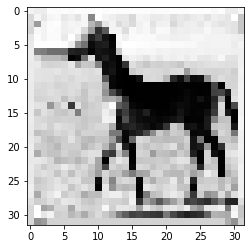

In [31]:
iter_ = 0
while iter_ < 2:
    model.eval()
    i = xdata[iter_]
    j = ydata[iter_]
    i = np.mean(i.reshape(image_size, image_size, 3), axis=2).reshape(32,32,1)
    pos_out = model(torch.from_numpy(i).float())
    neg_out = model(torch.from_numpy(j).reshape(-1, image_size, image_size,1).float())
    reconstructed = np.squeeze(np.array(model(pos_out).detach().numpy()))
    plt.imshow(reconstructed, cmap='gray')
    iter_ = iter_+1